In [266]:
import csv

def read_data(data):
   parsed_data = []
   with open(data) as csv_file:
       reader = csv.DictReader(csv_file)
       for row in reader:
           parsed_data.append(row)
   return parsed_data

In [267]:
# Create a list of the data files from which to import 
files = !ls mta_turnstyle_data/
print files

['turnstile_160312.txt', 'turnstile_160319.txt', 'turnstile_160326.txt', 'turnstile_160402.txt']


In [268]:
data = []

for file_name in files:
    path = "mta_turnstyle_data/" + file_name
    data += read_data(path)

In [269]:
# Making the dataset smaller just so I can print stuff
#data = data[0:1000]

# Challenge 1

- Open up a new IPython notebook
- Download a few MTA turnstile data files
- Open up a file, use csv reader to read it, make a python dict where there is a key for each (C/A, UNIT, SCP, STATION). These are the first four columns. The value for this key should be a list of lists. Each list in the list is the rest of the columns in a row. For example, one key-value pair should look like

{ ('A002','R051','02-00-00','LEXINGTON AVE'): [ ['NQR456', 'BMT', '01/03/2015', '03:00:00', 'REGULAR', '0004945474', '0001675324'], ['NQR456', 'BMT', '01/03/2015', '07:00:00', 'REGULAR', '0004945478', '0001675333'], ['NQR456', 'BMT', '01/03/2015', '11:00:00', 'REGULAR', '0004945515', '0001675364'], ... ] }

In [270]:
chal_1_dict = {}

for x in data:
    ca = x["C/A"]
    unit = x["UNIT"]
    scp = x["SCP"]
    station =  x["STATION"]

    my_tuple = (ca, unit, scp, station)

    linelame = x["LINENAME"]
    division =x["DIVISION"]
    date = x["DATE"]
    time = x["TIME"]
    desc = x["DESC"]
    entries = x["ENTRIES"]
    exits = x['EXITS                                                               ']
    # Removing all the whitespace that comes in the exits key
    exits = exits.strip()
    
    values_list = [linelame, division,date,time, desc, entries, exits]
        
    if my_tuple not in chal_1_dict:
        chal_1_dict[my_tuple] = [values_list]
    else:
        chal_1_dict[my_tuple] = chal_1_dict[my_tuple] + [values_list]

# Challenge 2

Let's turn this into a time series.

For each key (basically the control area, unit, device address and station of a specific turnstile), have a list again, but let the list be comprised of just the point in time and the count of entries.

This basically means keeping only the date, time, and entries fields in each list. You can convert the date and time into datetime objects -- That is a python class that represents a point in time. You can combine the date and time fields into a string and use the dateutil module to convert it into a datetime object. For an example check this StackOverflow question.

Your new dict should look something like

{ ('A002','R051','02-00-00','LEXINGTON AVE'): [ [datetime.datetime(2013, 3, 2, 3, 0), 3788], [datetime.datetime(2013, 3, 2, 7, 0), 2585], [datetime.datetime(2013, 3, 2, 12, 0), 10653], [datetime.datetime(2013, 3, 2, 17, 0), 11016], [datetime.datetime(2013, 3, 2, 23, 0), 10666], [datetime.datetime(2013, 3, 3, 3, 0), 10814], [datetime.datetime(2013, 3, 3, 7, 0), 10229], ... ], .... }

In [271]:
# Part 1 - Converting the dates & times

import dateutil.parser

chal_2_dict = {}

for key in chal_1_dict:
    for timestamp in chal_1_dict[key]:
        entries = int(timestamp[-2])
        date_unparsed = timestamp[2]
        time_unparsed = timestamp[3]
        date_time_combo = date_unparsed + " " + time_unparsed
        time_list = [dateutil.parser.parse(date_time_combo),entries]
        
        if key not in chal_2_dict:
            chal_2_dict[key] = [time_list]
        else:
            chal_2_dict[key] = chal_2_dict[key] + [time_list]

In [272]:
chal_2_dict = {turnstile: [[rows[i][0],
                                     rows[i+1][1] - rows[i][1]]
                                    for i in range(len(rows) - 1)]
                        for turnstile, rows in chal_2_dict.items()}    #make a new dictionary; keys will be the turnstiles, each will have a list of lists, each of which will give date, change in entries from last time, and elasped time

# Challenge 3

These counts are for every n hours. (What is n?) We want total daily entries.
Now make it that we again have the same keys, but now we have a single value for a single day, which is the total number of passengers that entered through this turnstile on this day.

n = 4 for most of the dataset. There are some occasions when n bumps to 5 hours (e.g. when the schedules goes from (in military time) 1900 to 2300 and then to 0400 and 0800). There are other times when there are "audits" which aren't taken on the hour, and occur at strange times like 5:37. This creates an arbitrary amount of time between itself and the previous/subsequent time.

In [273]:
# row[i][0] - This is the datetime elements
# row[i][1] - This is the entries elements

chal_3a_dict = {turnstile: [[rows[i][0],
                                     rows[i+1][1] - rows[i][1]]
                                    for i in range(len(rows) - 1)]
                        for turnstile, rows in chal_2_dict.items()}    #make a new dictionary; keys will be the turnstiles, each will have a list of lists, each of which will give date, change in entries from last time, and elasped time

In [274]:
chal_3b_dict = {turnstile: [(time, count)
                               for (time, count) in rows
                               if 0 <= count <= 5000]
                   for turnstile, rows in chal_3a_dict.items()}    #make one more dictionary; keys will be turnstiles, each will have a list of lists with date and change in entries

In [275]:
chal_3c_dict = {}    #an empty dictionary to hold the total counts
for turnstile, rows in chal_3b_dict.items():    #loop over key/data pairs in datetime_counts
    by_day = {}    #for each make a new empty dictionary
    for time, count in rows:    #loop over the time and the count
        day = time.date()    #keep only the day info
        by_day[day] = by_day.get(day, 0) + count    #pull out the data associated with key <day> and add the count to it - if <day> is in the dictionary return 0
    chal_3c_dict[turnstile] = sorted(by_day.items())    #save the count by turnstile in the dictionary

# Challenge 4

We will plot the daily time series for a turnstile.

In ipython notebook, add this to the beginning of your next cell:

%matplotlib inline
This will make your matplotlib graphs integrate nicely with the notebook. To plot the time series, import matplotlib with

import matplotlib.pyplot as plt

Take the list of [(date1, count1), (date2, count2), ...], for the turnstile and turn it into two lists: dates and counts. This should plot it:

plt.figure(figsize=(10,3))
plt.plot(dates,counts)

In [276]:
%matplotlib inline
import matplotlib.pyplot as plt

In [277]:
def plot_turnstyle_volume_chal4(key, dictionary):
    '''This takes an input like the following and makes a plot of counts for all the date/count pairs they have. 
    ('A002', 'R051', '02-00-00', '59 ST')
    '''
    dates = []
    counts = []
    for value in dictionary[key]:
        dates.append(value[0]) 
        counts.append(value[1])
    #print dates
    #print counts
    
    plt.figure(figsize=(20,5))
    plt.plot(dates,counts)

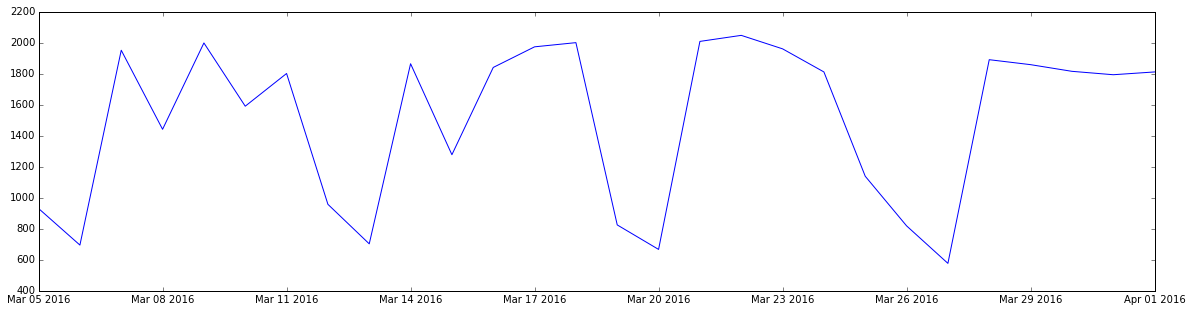

In [278]:
plot_turnstyle_volume_chal4(('R245A', 'R051', '01-00-00', '59 ST'),chal_3c_dict)

In [279]:
chal_3c_dict[('R245A', 'R051', '01-00-00', '59 ST')]

[(datetime.date(2016, 3, 5), 931),
 (datetime.date(2016, 3, 6), 695),
 (datetime.date(2016, 3, 7), 1952),
 (datetime.date(2016, 3, 8), 1442),
 (datetime.date(2016, 3, 9), 1999),
 (datetime.date(2016, 3, 10), 1591),
 (datetime.date(2016, 3, 11), 1802),
 (datetime.date(2016, 3, 12), 958),
 (datetime.date(2016, 3, 13), 703),
 (datetime.date(2016, 3, 14), 1865),
 (datetime.date(2016, 3, 15), 1278),
 (datetime.date(2016, 3, 16), 1841),
 (datetime.date(2016, 3, 17), 1974),
 (datetime.date(2016, 3, 18), 2001),
 (datetime.date(2016, 3, 19), 825),
 (datetime.date(2016, 3, 20), 667),
 (datetime.date(2016, 3, 21), 2009),
 (datetime.date(2016, 3, 22), 2048),
 (datetime.date(2016, 3, 23), 1961),
 (datetime.date(2016, 3, 24), 1812),
 (datetime.date(2016, 3, 25), 1139),
 (datetime.date(2016, 3, 26), 819),
 (datetime.date(2016, 3, 27), 577),
 (datetime.date(2016, 3, 28), 1891),
 (datetime.date(2016, 3, 29), 1859),
 (datetime.date(2016, 3, 30), 1816),
 (datetime.date(2016, 3, 31), 1794),
 (datetime.dat

# Challenge 5

So far we've been operating on a single turnstile level, let's combine turnstiles in the same ControlArea/Unit/Station combo. There are some ControlArea/Unit/Station groups that have a single turnstile, but most have multiple turnstilea-- same value for the C/A, UNIT and STATION columns, different values for the SCP column.
We want to combine the numbers together -- for each ControlArea/UNIT/STATION combo, for each day, add the counts from each turnstile belonging to that combo.

In [280]:
chal_5_dict = {}

for turnstile,day_time_count_list_of_tuples in chal_3c_dict.items():
    # (Preparation Step) Massaging the key...
    # Extract out the control area, unit, and turnstyle of each key.
    control = turnstile[0]
    unit = turnstile[1]
    station = turnstile[3]
    
    control_unit_station_tuple = (control,unit,station)
    
    # (Preparation Step) Massaing the values...
    # This is nec. because later I will have to update the counts. Since tuples are immutable, it wouldn't update.
       # day_time_count_list_of_lists = map(list, day_time_count_list_of_tuples)
    
    #The keys will be dates, the values will be a rolling sum for a given station (iterating across all the turnstyles)
    date_sum = {}
    
    for day_times,counts in day_time_count_list_of_tuples:
        date_sum[day_times] = date_sum.get(day_times, 0) + counts
    
    if control_unit_station_tuple in chal_5_dict:
        preexisting_station_dictionary = chal_5_dict[control_unit_station_tuple]

        for temp_times,temp_counts in date_sum.items():
            preexisting_station_dictionary[temp_times] = preexisting_station_dictionary.get(temp_times, 0) + temp_counts
    else:
        chal_5_dict[control_unit_station_tuple] = date_sum   #This takes out all the values of the date dictionary 

# Challenge 6

Similarly, combine everything in each station, and come up with a time series of [(date1, count1),(date2,count2),...] type of time series for each STATION, by adding up all the turnstiles in a station.

In [281]:
chal_6_dict = {}

for control_unit_station,day_time_count_list_of_tuples in chal_5_dict.items():
    # (Preparation Step) Massaging the key...
    # Extract out the station
    station = control_unit_station[2]
        
    # (Preparation Step) Massaing the values...
    # This is nec. because later I will have to update the counts. Since tuples are immutable, it wouldn't update.
       # day_time_count_list_of_lists = map(list, day_time_count_list_of_tuples)
    
    #The keys will be dates, the values will be a rolling sum for a given station (iterating across all the turnstyles)
    date_sum = {}
    
    for day_times,counts in day_time_count_list_of_tuples.items():
        date_sum[day_times] = date_sum.get(day_times, 0) + counts
    
    if station in chal_6_dict:
        preexisting_station_dictionary = chal_6_dict[station]

        for temp_times,temp_counts in date_sum.items():
            preexisting_station_dictionary[temp_times] = preexisting_station_dictionary.get(temp_times, 0) + temp_counts
    else:
        chal_6_dict[(station,)] = date_sum   #This takes out all the values of the date dictionary 

# Challenge 7

Plot the time series for a station.

In [285]:
import pandas as pd

def plot_turnstyle_volume_chal6(key, dictionary):
    '''This takes an input like the following and prints 
    ('A002', 'R051', '02-00-00', '59 ST')
    '''
    #for date,count in dictionary[key].items(): # For some reason there's a difference b/w how chal_6_dict and chal_3_dict is created, so I need to re-create this function and add in the "items" part.
    
    data = sorted([(date,count) for date,count in dictionary[key].items()])
    data_and_counts_separated = zip(*data)
    
    plt.figure(figsize=(20,5))
    plt.plot(data_and_counts_separated[0],data_and_counts_separated[1])

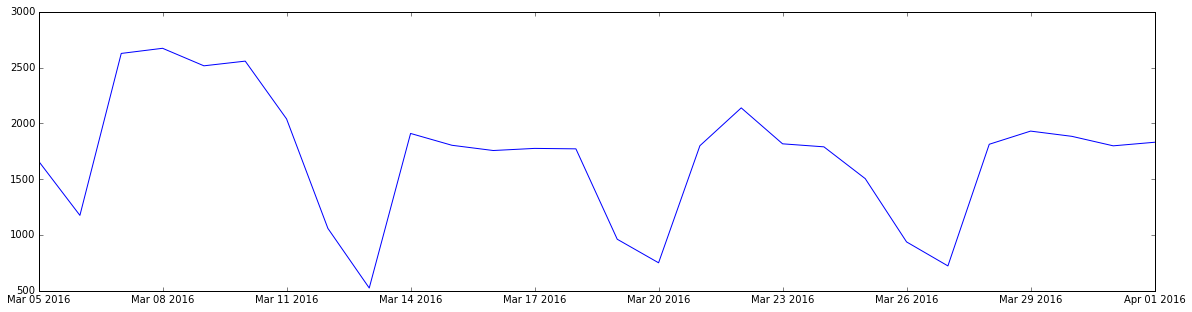

In [286]:
plot_turnstyle_volume_chal6(('59 ST',),chal_6_dict)

# Challenge 8

Make one list of counts for one week for one station. Monday's count, Tuesday's count, etc. so it's a list of 7 counts. Make the same list for another week, and another week, and another week. plt.plot(week_count_list) for every week_count_list you created this way. You should get a rainbow plot of weekly commute numbers on top of each other.

(1662, 1176, 2627, 2673, 2516, 2558, 2040)
(962, 751, 1800, 2139, 1817, 1790, 1505)
(1059, 525, 1910, 1804, 1757, 1776, 1772)
(938, 723, 1813, 1931, 1884, 1799, 1831)


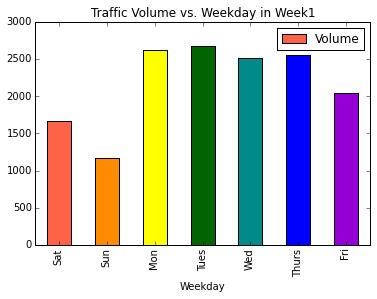

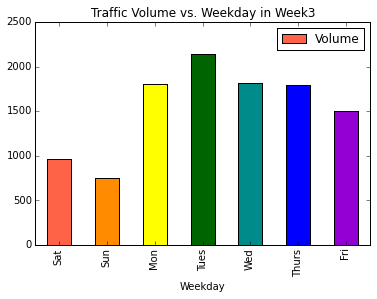

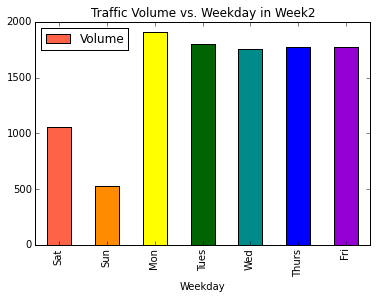

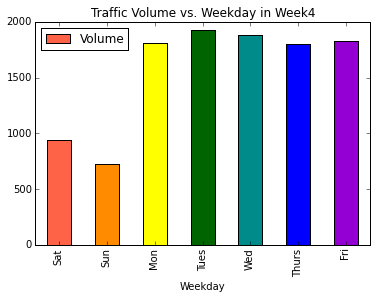

In [287]:
# Takes the output of chal_6_dict[('59 ST',)] which is a dictionary of date-count pairs, and 
# and transforms it into a tuple of the form (date, count, weekday). 0 is a monday, 1 is tuesday
# and so on and so forth. 

data = sorted([(date,count,date.weekday()) for date,count in chal_6_dict[('59 ST',)].iteritems()])


####### Separate the data into distinct groups of weeks.##############
# Some Preliminary Set-up
starting_weekday = data[0][2]
week_group = 0
from collections import defaultdict
weekly_data_dictionary = defaultdict()


# The Meat...
for i in range(len(data)):          #This works because the data is already sorted.  
    # Create a new dictionary for each new week
    if data[i][2] == starting_weekday:  #If the day of the week is the same as the first week, it creates a new key to put data into
        week_group += 1
        key = "Week" + str(week_group)
        weekly_data_dictionary[key] = [data[i]]  # Set the first value of the default dict to the first saturday        
    # Otherwise, add it to the exisitng dictionary
    else:
        weekly_data_dictionary[key] = weekly_data_dictionary[key] + [data[i]]

list_of_weekly_groupes = weekly_data_dictionary.keys()

for list in list_of_weekly_groupes: 
    data_and_counts_separated = zip(*weekly_data_dictionary[list])
    print data_and_counts_separated[1]
    #dates = list(data_and_counts_separated[0])
    counts = data_and_counts_separated[1]
    #weekdays = list(data_and_counts_separated[2])
    df=pd.DataFrame({'Weekday':['Sat','Sun','Mon','Tues','Wed','Thurs','Fri'],
         'Volume':counts})
    df.plot(kind='bar',x='Weekday',color=["tomato", "darkorange", "yellow",
                                      "darkgreen", "darkcyan", "blue","darkviolet"], title = "Traffic Volume vs. Weekday in " + list)


# This seems to reorder the values from greatest to least
# my_labels=["Sat","Sun","Mon","Tues","Wed","Thurs","Fri"]
# plt.bar(weekdays, counts, width=0.3, color=["tomato", "darkorange", "yellow","darkgreen", "darkcyan", "blue","darkviolet"])
# ax = plt.gca()
# ax.set_xticklabels(my_labels, rotation=45)
# plt.xlabel("Weekday")
# plt.ylabel("Station Volume")
# plt.title("Station Volume vs. Weekday over week: ",y=1.1)
# plt.show
# plt.scatter(weekdays,counts)

# Challenge 9

Over multiple weeks, sum total ridership for each station and sort them, so you can find out the stations with the highest traffic during the time you investigate

In [345]:
    #an empty dictionary to hold the total counts
# for station, date_counts in chal_6_dict.items():    
#     total_station_volume = 0
#     print date_counts
#     for time, count in date_counts:    #loop over the time and the count
#         total_station_volume += count
#     chal_9_dict[station] = total_station_volume    

station_list = []
counts_list = []

for station,date_counts in chal_6_dict.items():
        total_station_volume = 0
        for date,counts in date_counts.items():
            total_station_volume += counts
        station_list.append(station[0])  # Taking the station out of the tuple...
        counts_list.append(total_station_volume)

chal_9_df = pd.DataFrame(counts_list, index = station_list,columns = ["Station Volume"])

In [347]:
chal_9_df.sort(columns = "Station Volume", ascending = False)

,Station Volume
PATH WTC,477252
47-50 STS ROCK,395576
68ST-HUNTER CO,303819
LEXINGTON AV/53,284654
34 ST-HERALD SQ,283156
CHAMBERS ST,278746
BEDFORD AV,272600
THIRTY THIRD ST,268665
GRD CNTRL-42 ST,267245
34 ST-PENN STA,258055


# Challenge 10

Make a single list of these total ridership values and plot it with

plt.hist(total_ridership_counts)

to get an idea about the distribution of total ridership among different stations.

This should show you that most stations have a small traffic, and the histogram bins for large traffic volumes have small bars.

Additional Hint:

If you want to see which stations take the meat of the traffic, you can sort the total ridership counts and make a plt.bar graph. For this, you want to have two lists: the indices of each bar, and the values. The indices can just be 0,1,2,3,..., so you can do

indices = range(len(total_ridership_values))
plt.bar(indices, total_ridership_values)

(array([ 171.,  110.,   41.,   29.,   11.,    8.,    1.,    0.,    1.,    1.]),
 array([  6.80000000e+01,   4.77864000e+04,   9.55048000e+04,
          1.43223200e+05,   1.90941600e+05,   2.38660000e+05,
          2.86378400e+05,   3.34096800e+05,   3.81815200e+05,
          4.29533600e+05,   4.77252000e+05]),
 <a list of 10 Patch objects>)

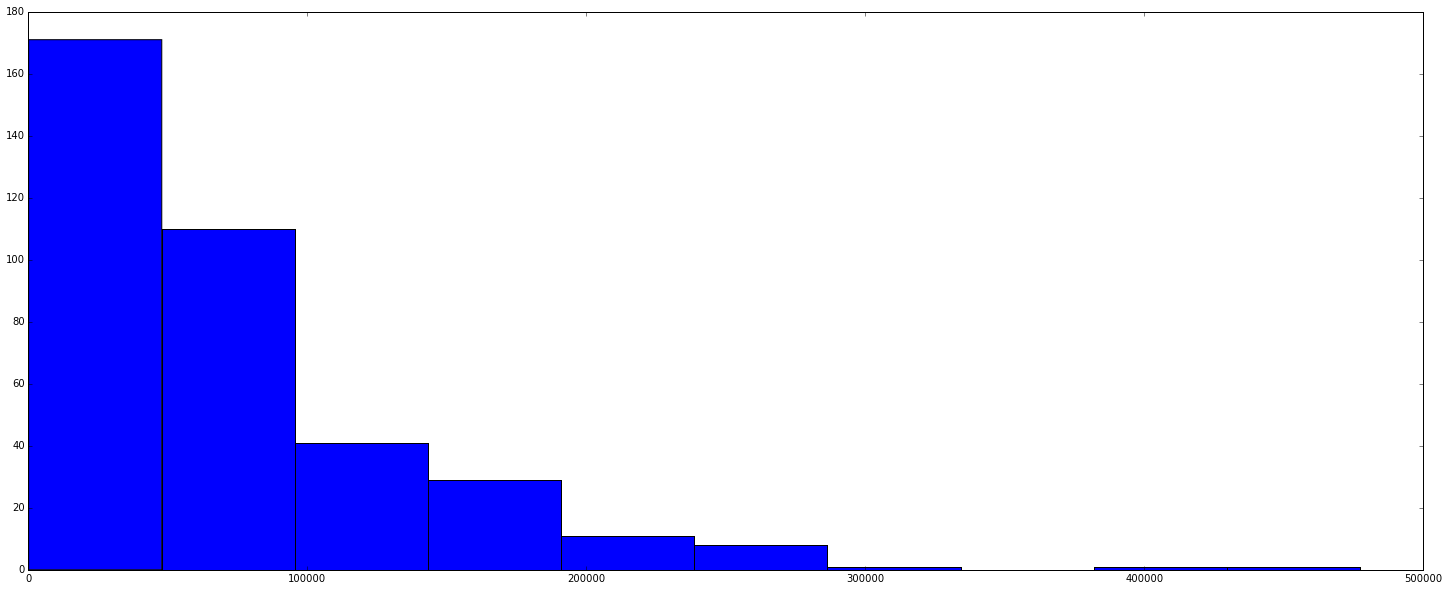

In [356]:
plt.figure(figsize=(25,10))
plt.hist(chal_9_df["Station Volume"])

<Container object of 373 artists>

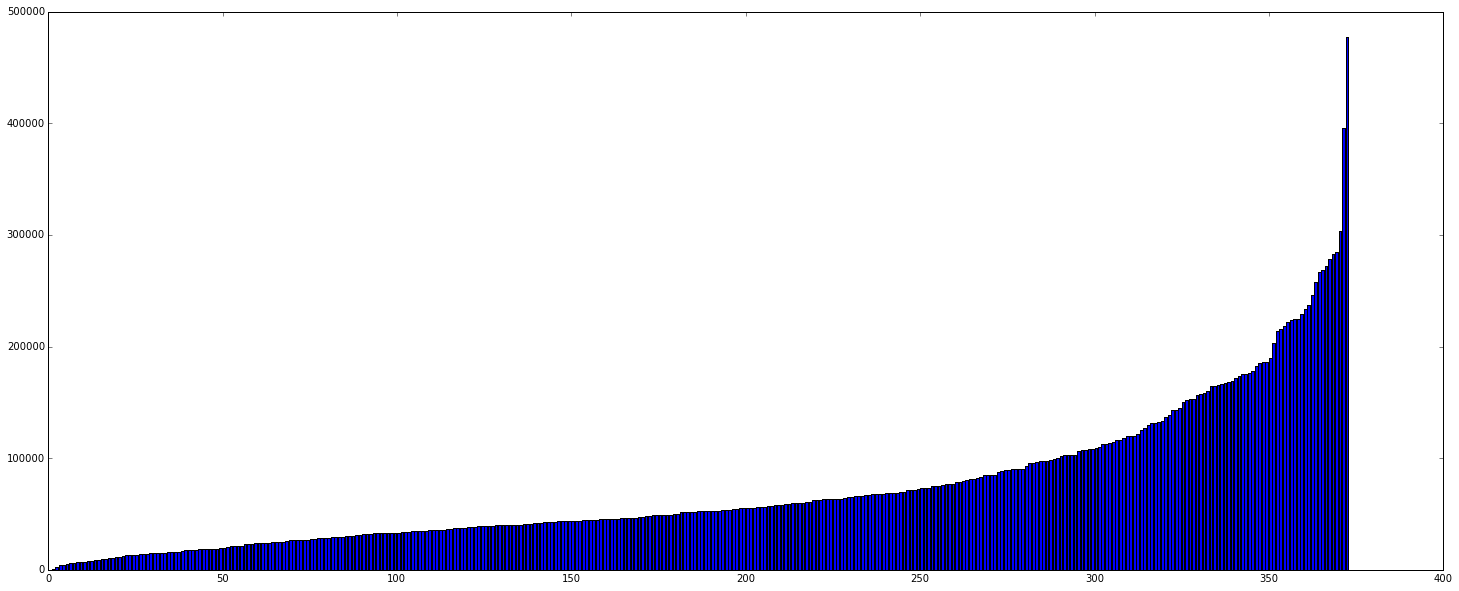

In [365]:
indices = range(len(chal_9_df["Station Volume"])) 
plt.figure(figsize=(25,10))
plt.bar(indices, sorted(chal_9_df["Station Volume"]))